**Dataset Loading**

In [ ]:
#importing the libraries
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:

apple_df = pd.read_csv('AAPL.csv')

In [ ]:
apple_df.shape

In [ ]:

apple_df.head()

**Data Pre-Processing**

In [ ]:
#checking for null values
apple_df.isna().sum()

In [ ]:
apple_df.info()


In [ ]:
#sort the indexes
apple_df.sort_index(inplace = True)

In [ ]:
apple_df.head()

In [ ]:
#deleting the columns
apple_df.drop(columns = ['date'], inplace = True)
apple_df.drop(columns = ['adjClose'], inplace = True)
apple_df.drop(columns = ['adjHigh'], inplace = True)
apple_df.drop(columns = ['adjLow'], inplace = True)
apple_df.drop(columns = ['adjOpen'], inplace = True)
apple_df.drop(columns = ['adjVolume'], inplace = True)
apple_df.drop(columns = ['divCash'], inplace = True)
apple_df.drop(columns = ['splitFactor'], inplace = True)

In [ ]:
apple_df.head()

In [ ]:
#normalizing the data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(apple_df.drop(columns=['symbol', 'Unnamed: 0']))

In [ ]:
scaled_values

In [ ]:
#converting the array into dataframe
apple_scaled_df = pd.DataFrame(scaled_values, columns = apple_df.drop(columns=['symbol', 'Unnamed: 0']).columns, index = apple_df.index)

In [ ]:
apple_scaled_df.head()

**Plotting the Columns**

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
figure, axes = plt.subplots(5)

for ax, col in zip(axes, apple_scaled_df.columns):
  ax.plot(apple_scaled_df[col])
  ax.set_title(col)
  ax.axes.xaxis.set_visible(False)

**Create the Sliding Window Sequences**

In [ ]:
window_size = 60

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(X), np.array(y)

X, y = create_sequence(apple_scaled_df, window_size)

In [ ]:
X.shape, y.shape

In [ ]:
#train-test-split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
X_train.shape[1], X_train.shape[2], y_train.shape[1]

 **Building the LSTM model**

In [ ]:
model = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Adding a Dense output layer
    keras.layers.Dense(y_train.shape[1])
])

In [ ]:
#compilation
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])

In [ ]:
#Early stopping condition
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

In [130]:
history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100,
                    batch_size=3,
                    callbacks=[early_stopping])

Epoch 1/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - RootMeanSquaredError: 0.0666 - loss: 0.0045 - val_RootMeanSquaredError: 0.0586 - val_loss: 0.0034
Epoch 2/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - RootMeanSquaredError: 0.0668 - loss: 0.0045 - val_RootMeanSquaredError: 0.0516 - val_loss: 0.0027
Epoch 3/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - RootMeanSquaredError: 0.0610 - loss: 0.0037 - val_RootMeanSquaredError: 0.0527 - val_loss: 0.0028
Epoch 4/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - RootMeanSquaredError: 0.0626 - loss: 0.0039 - val_RootMeanSquaredError: 0.0514 - val_loss: 0.0026
Epoch 5/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - RootMeanSquaredError: 0.0639 - loss: 0.0041 - val_RootMeanSquaredError: 0.0501 - val_loss: 0.0025
Epoch 6/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - RootMeanSquaredError: 0.0583 - loss: 0.0034 - val_RootMeanSquaredError: 0.0613 - val_loss: 0.0038
Epoch 7/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - RootMeanSquar

In [131]:
# Making predictions on the test data
predictions = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


In [132]:
# Inverse scaling to get the original values
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

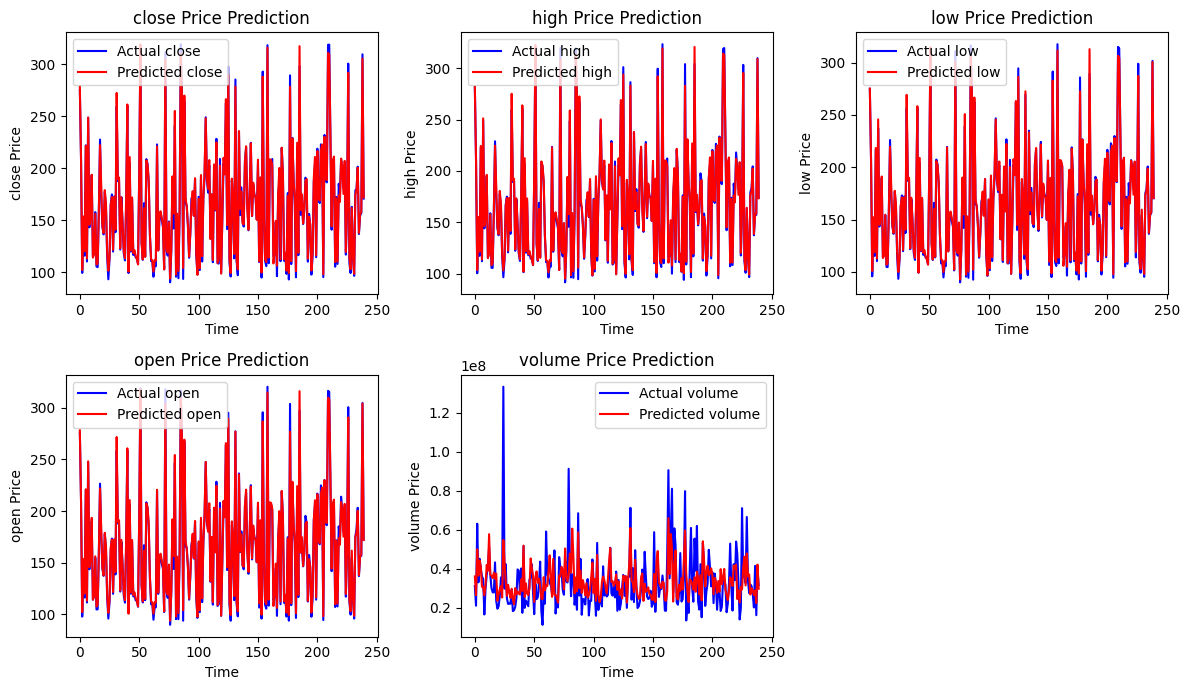

In [139]:
# Plotting the results
plt.figure(figsize=(12, 7))

for i, col in enumerate(apple_scaled_df.columns):
    plt.subplot(2, 3, i + 1)
    plt.plot(y_test_rescaled[:, i], color='blue', label=f'Actual {col}')
    plt.plot(predictions[:, i], color='red', label=f'Predicted {col}')
    plt.title(f'{col} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Price')
    plt.legend()

plt.tight_layout()